<a href="https://colab.research.google.com/github/Zakibrahmi/Hyperparameter_Tuning-_RayTune/blob/main/Example_RayTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install "ray[tune]" torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 10.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [5]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [6]:
import os
import tempfile

from ray.train import Checkpoint

def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)


        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            train.report({"mean_accuracy": acc}, checkpoint=checkpoint)


In [7]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]


Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.48MB/s]


Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



2024-11-07 03:28:44,315	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-07 03:28:46,103	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     train_mnist_2024-11-07_03-28-40   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 1                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_mnist_2024-11-07_03-28-40
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-11-07_03-28-40_935561_335/artifacts/2024-11-07_03-28-46/train_mnist_2024-11-07_03-28-40/driver_artifacts`

Trial status: 1 PENDING
Current time: 2024-11-07 03:28:46. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------+
| Trial name                status       moment

(train_mnist pid=2185) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_mnist_2024-11-07_03-28-40/train_mnist_65710_00000_0_momentum=0.6876_2024-11-07_03-28-46/checkpoint_000000)
2024-11-07 03:28:57,408	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_mnist_2024-11-07_03-28-40' in 0.0052s.



Trial train_mnist_65710_00000 completed after 10 iterations at 2024-11-07 03:28:57. Total running time: 10s
+------------------------------------------------------------+
| Trial train_mnist_65710_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   0.29594 |
| time_total_s                                       3.22733 |
| training_iteration                                      10 |
| mean_accuracy                                      0.13125 |
+------------------------------------------------------------+

Trial status: 1 TERMINATED
Current time: 2024-11-07 03:28:57. Total running time: 10s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         momentum       acc     iter     total time (s) |
+-------

[<Axes: >]

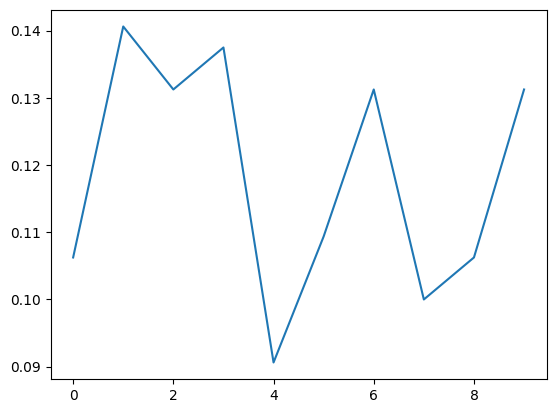

In [8]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

This code snippet sets up and runs a hyperparameter tuning experiment using Ray Tune with the ASHA (Asynchronous Successive Halving Algorithm) scheduler, which optimizes the training function train_mnist. ASHA allows to integrate an early stopping into the optimization process. Furthermore, it early terminate bad trials, pause trials, clone trials, and alter hyperparameters of a running trial. *train_mnist* is the function that will be executed for each trial.

In [9]:
tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=20,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.path: result.metrics_dataframe for result in results}

+--------------------------------------------------------------------+
| Configuration for experiment     train_mnist_2024-11-07_03-30-24   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 20                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_mnist_2024-11-07_03-30-24
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-11-07_03-28-40_935561_335/artifacts/2024-11-07_03-30-24/train_mnist_2024-11-07_03-30-24/driver_artifacts`

Trial status: 20 PENDING
Current time: 2024-11-07 03:30:24. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------+
| Trial name                status       mom

(train_mnist pid=2635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_mnist_2024-11-07_03-30-24/train_mnist_a0177_00000_0_momentum=0.4135_2024-11-07_03-30-24/checkpoint_000000)



Trial train_mnist_a0177_00000 completed after 10 iterations at 2024-11-07 03:30:40. Total running time: 15s
+------------------------------------------------------------+
| Trial train_mnist_a0177_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   0.47422 |
| time_total_s                                       5.89498 |
| training_iteration                                      10 |
| mean_accuracy                                       0.0875 |
+------------------------------------------------------------+

Trial train_mnist_a0177_00001 completed after 10 iterations at 2024-11-07 03:30:40. Total running time: 15s
+------------------------------------------------------------+
| Trial train_mnist_a0177_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name     

(train_mnist pid=2842) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_mnist_2024-11-07_03-30-24/train_mnist_a0177_00003_3_momentum=0.7258_2024-11-07_03-30-24/checkpoint_000000) [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)



Trial train_mnist_a0177_00003 completed after 10 iterations at 2024-11-07 03:31:01. Total running time: 37s
+------------------------------------------------------------+
| Trial train_mnist_a0177_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   0.45953 |
| time_total_s                                       7.43891 |
| training_iteration                                      10 |
| mean_accuracy                                       0.9125 |
+------------------------------------------------------------+

Trial train_mnist_a0177_00004 started with configuration:
+-------------------------------------------------+
| Trial train_mnist_a0177_00004 config            |
+-------------------------------------------------+
| lr                                            0 |
| momentum                                 0.7657 |
+----

2024-11-07 03:33:00,413	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_mnist_2024-11-07_03-30-24' in 0.0189s.



Trial train_mnist_a0177_00018 completed after 4 iterations at 2024-11-07 03:33:00. Total running time: 2min 35s
+--------------------------------------------------+
| Trial train_mnist_a0177_00018 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         0.47159 |
| time_total_s                             2.03921 |
| training_iteration                             4 |
| mean_accuracy                            0.08125 |
+--------------------------------------------------+

Trial status: 20 TERMINATED
Current time: 2024-11-07 03:33:00. Total running time: 2min 35s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------+
| Trial name                status         momentum        acc     iter     total time (s) |
+-------------------------------------------------------------------------------------

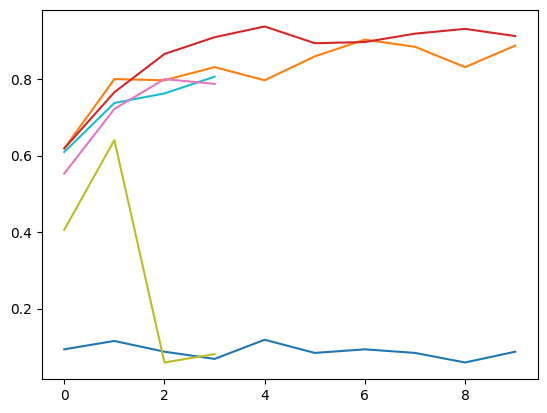

In [10]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)